In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import seaborn as sns
import plotly.express as px
style.use('classic')

In [2]:
import os
TITANIC_PATH = '../datasets/titanic'

def load_titanic(titanic_path=TITANIC_PATH, test=False):
  csv_path = os.path.join(titanic_path, 'test.csv' if test else 'train.csv')
  return pd.read_csv(csv_path)

In [3]:
training = load_titanic(test=False)
test = load_titanic(test=True)

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training, test])

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


### Data exploration
1. Numeric data
- Histograms
- Correlation matrix
- Pivot tables comparing survival rates
2. Categorical data
- Bar charts
- Pivot tables comparing survival rates

In [4]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [5]:
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = training[['Survived', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']]

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

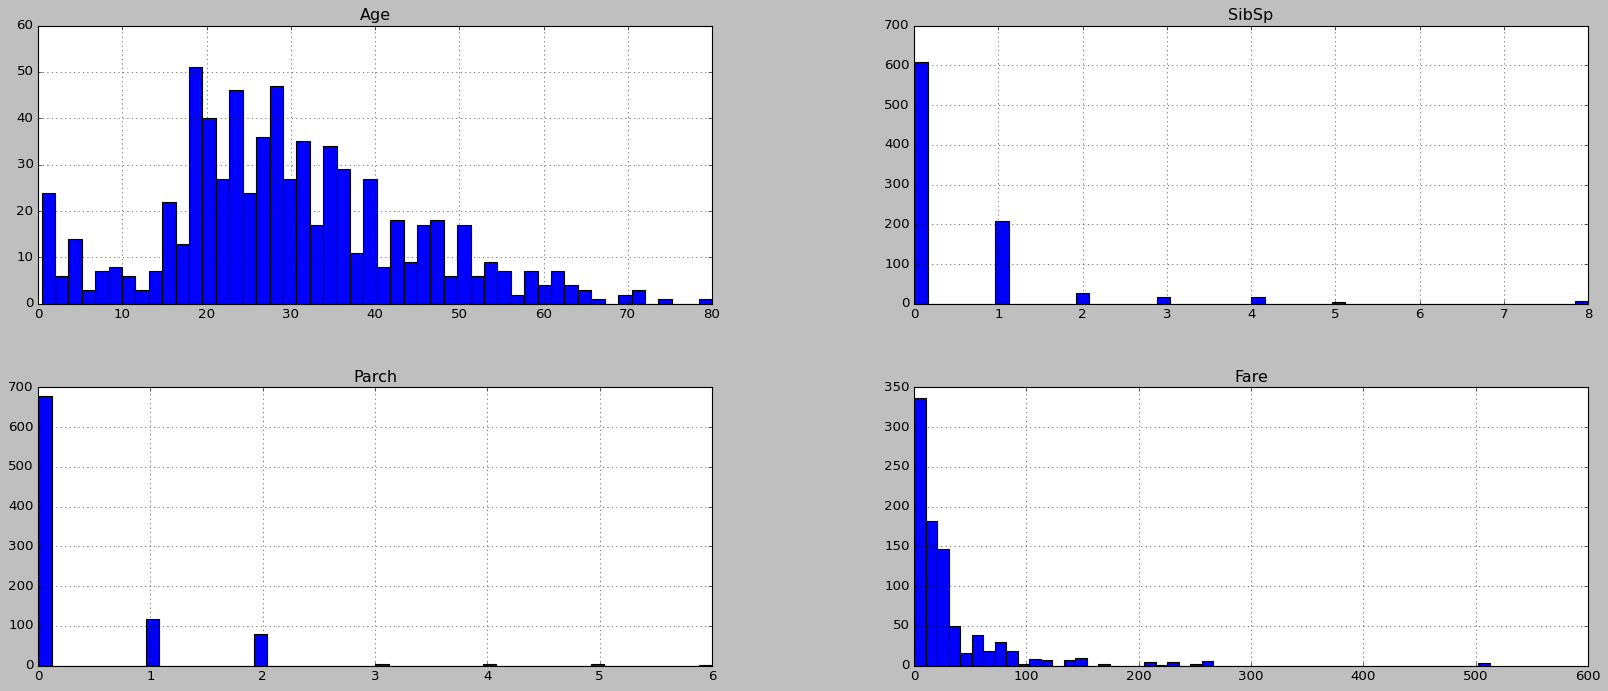

In [6]:
df_num.hist(bins=50, figsize=(25, 10))

Fare has an uneven distribution so I will try to normalize it.

In [7]:
corr_matrix = df_num.corr()
corr_matrix

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


In [8]:
pd.pivot_table(training, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [9]:
px.scatter(training, x='PassengerId', y='Age', color='Survived', log_x=True, size='Fare')

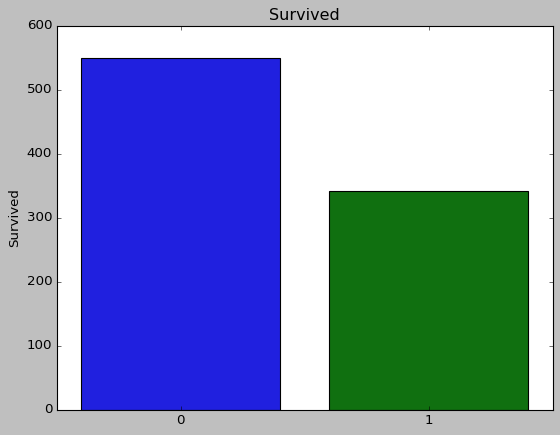

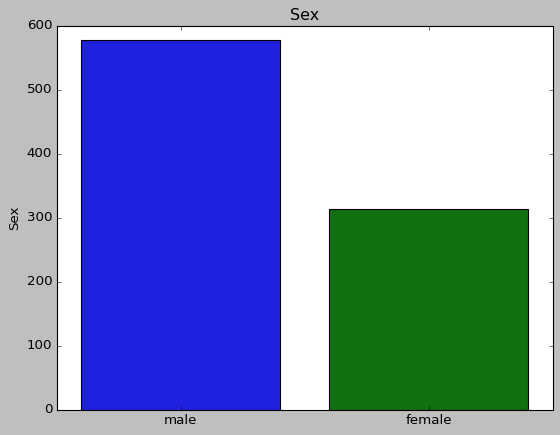

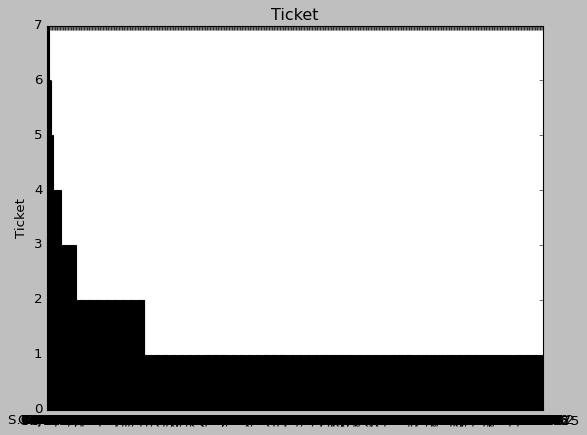

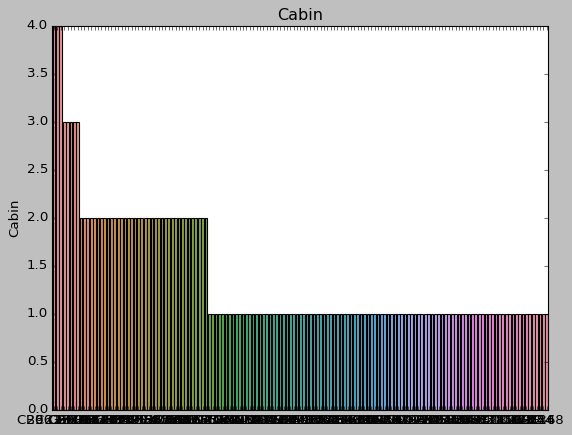

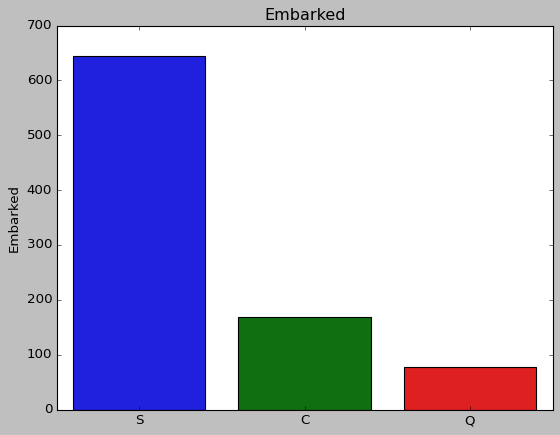

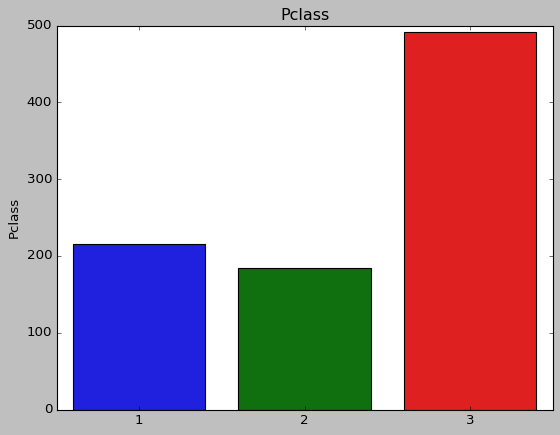

In [10]:
for (category_name, category_data) in df_cat.iteritems():
  sns.barplot(x=category_data.value_counts().index, y=category_data.value_counts()).set_title(category_name)
  plt.show()

In [11]:
pd.pivot_table(training, index='Survived', columns='Sex', values='Ticket', aggfunc='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


In [12]:
pd.pivot_table(training, index='Survived', columns='Embarked', values='Ticket', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [13]:
pd.pivot_table(training, index='Survived', columns='Pclass', values='Ticket', aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


### Feature engineering
1. Cabins - Does number of cabins or cabin letter impact survival
2. Tickets - Do different ticket types impact survival

In [14]:
num_cabins = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
training['num_cabins'] = num_cabins

pd.pivot_table(training, index='Survived', columns='num_cabins', values='Ticket', aggfunc='count')

num_cabins,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [15]:
px.histogram(training, x='num_cabins', color='Survived', color_discrete_sequence=['crimson','darkseagreen'], barmode='group')

In [16]:
cabin_letter = training.Cabin.apply(lambda x: str(x)[0])
training['cabin_letter'] = cabin_letter

pd.pivot_table(training, index='Survived', columns='cabin_letter', values='Ticket', aggfunc='count')

cabin_letter,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [17]:
px.histogram(training, x='cabin_letter', color='Survived', color_discrete_sequence=['crimson','darkseagreen'], barmode='group')

### Data preprocessing
1. Drop null values for Embarked (only 2)
2. Include only relevant atributes
3. Do categorical transform on all data
4. Impute data with mean
5. Normalize fare
6. Scale data (0-1)

In [18]:
# transform all data as we did training
all_data['num_cabins'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_letter'] = training.Cabin.apply(lambda x: str(x)[0])

# drop null values of embarked
all_data.dropna(subset=['Embarked'], inplace=True)

# impute Age and Fare with mean
all_data.Age.fillna(all_data.Age.median(), inplace=True)
all_data.Fare.fillna(all_data.Fare.median(), inplace=True)

# normalize fare
all_data['norm_fare'] = np.log(all_data.Fare+1)

# one hot encoding of categorical data
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_letter', 'num_cabins', 'train_test']])

X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1)

y_train = all_data[all_data.train_test == 1].Survived

In [19]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'norm_fare', 'SibSp', 'Parch']] = scaler.fit_transform(all_dummies_scaled[['Age', 'norm_fare', 'SibSp', 'Parch']])

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

### Model building (Base Performance)

In [20]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import VotingClassifier

def model_performance(model):
  cv = cross_val_score(model, X_train_scaled, y_train, cv=5)
  print('-----',model.__class__.__name__,'-----')
  print('Scores: \t',cv)
  print('Scores mean: \t',cv.mean())
  return cv.mean()
  
def model_performance_roc(model):
  y_pred = cross_val_predict(model, X_train_scaled, y_train, cv=5, method="predict_proba")
  y_score = y_pred[:, 1]
  auc_score = roc_auc_score(y_train, y_score)
  print('ROC AUC score: \t', auc_score)
  return {'y_score': y_score, 'auc_score': auc_score}
  
def plot_model_performance(performances):
  perf_vals = list(performances.values())
  names = list(performances.keys())
  
  min = np.min(perf_vals)
  max = np.max(perf_vals)
  
  figure(figsize=(20, 10))
  sns.barplot(x=names, y=perf_vals)
  
  plt.ylim(min - 0.01, max + 0.01)
  plt.yticks(perf_vals)
  plt.gca().yaxis.grid(True)
  plt.title('Algorithm performance (min - 0.01, max + 0.01)')
  
def plot_roc_performance(roc_performances):
  auc_vals = list(map(lambda x: x['auc_score'], roc_performances.values()))
  names = list(roc_performances.keys())
  
  min = np.min(auc_vals)
  max = np.max(auc_vals)
  
  figure(figsize=(20, 10))
  plt.subplot(121)
  for name, perf in roc_performances.items():  
    fpr, tpr, _ = roc_curve(y_train, perf['y_score'])
    plt.plot(fpr, tpr, '--', label=name)
  
  plt.plot([0,1], [0,1], 'k--')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.title('ROC curve')
  
  plt.subplot(122)
  sns.barplot(x=names, y=auc_vals)
  plt.ylim(min - 0.01, max + 0.01)
  plt.yticks(auc_vals)
  plt.gca().yaxis.grid(True)
  plt.title('Area under curve (min - 0.01, max + 0.01)')
    

def plot_models_performance(models, roc=True):
  performances = dict.fromkeys(models, 0.0)
  roc_performances = dict.fromkeys(models, {'y_score': 0.0, 'auc_score': 0.0})

  for name, model in models.items():
    performance = model_performance(model)
    roc_performance = model_performance_roc(model)
    performances[name] = performance
    roc_performances[name] = roc_performance

  plot_model_performance(performances)
  if roc:
    plot_roc_performance(roc_performances)
  

----- GaussianNB -----
Scores: 	 [0.69101124 0.67977528 0.70786517 0.73033708 0.76271186]
Scores mean: 	 0.7143401256903447
ROC AUC score: 	 0.7534554805528768
----- LogisticRegression -----
Scores: 	 [0.78089888 0.80337079 0.78089888 0.78651685 0.81920904]
Scores mean: 	 0.79417888656129
ROC AUC score: 	 0.850750026786671
----- RandomForestClassifier -----
Scores: 	 [0.78089888 0.79775281 0.82022472 0.75280899 0.82485876]
Scores mean: 	 0.7953088300641147
ROC AUC score: 	 0.8514089788921033
----- SVC -----
Scores: 	 [0.8258427  0.8258427  0.81460674 0.79775281 0.83615819]
Scores mean: 	 0.820040627182124
ROC AUC score: 	 0.8462311153969784
----- KNeighborsClassifier -----
Scores: 	 [0.80898876 0.78651685 0.82022472 0.82022472 0.83615819]
Scores mean: 	 0.8144226496540341
ROC AUC score: 	 0.8457864566591664


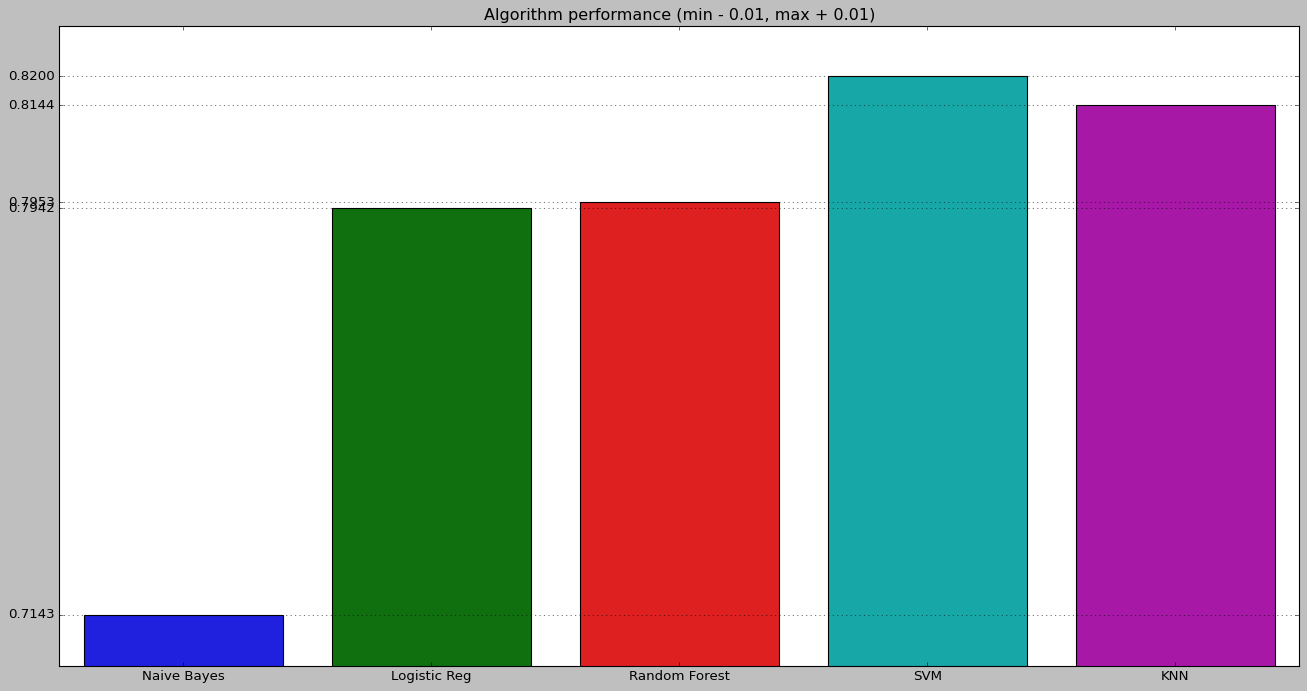

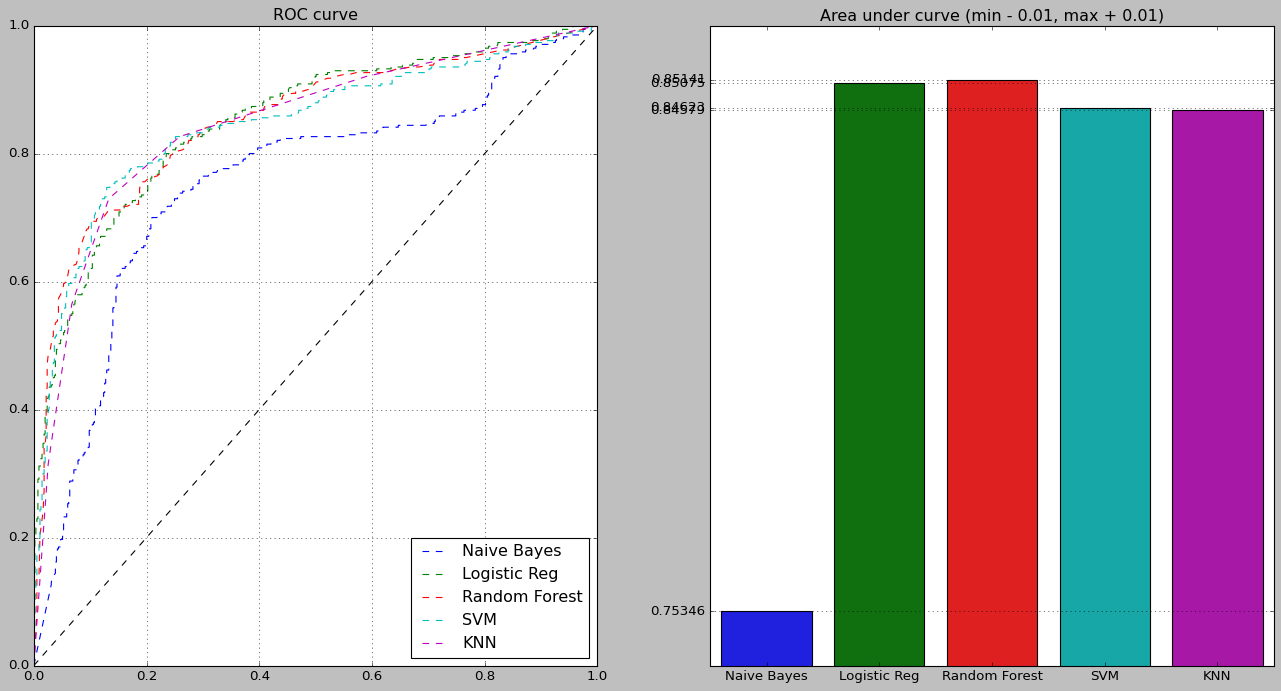

In [22]:
models = {'Naive Bayes': GaussianNB(),
          'Logistic Reg': LogisticRegression(),
          'Random Forest': RandomForestClassifier(random_state=42),
          'SVM': SVC(random_state=42, probability=True),
          'KNN': KNeighborsClassifier()}

plot_models_performance(models)

### Model hyperparameter tuning

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
tuned_models = {'Logistic Reg': LogisticRegression(),
                'Random Forest': RandomForestClassifier(random_state=42),
                'SVM': SVC(random_state=42, probability=True),
                'KNN': KNeighborsClassifier()}

In [24]:
lr = LogisticRegression()
param_grid = {'max_iter': [2000],
              'penalty': ['l1', 'l2'],
              'C': np.logspace(-4, 4, 20),
              'solver': ['liblinear']}

lr_clf = GridSearchCV(lr, param_grid, cv=5, verbose=3, n_jobs=1)
best_lr_clf = lr_clf.fit(X_train_scaled, y_train)
tuned_models['Logistic Reg'] = best_lr_clf.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.0001, max_iter=2000, penalty=l1, solver=liblinear;, score=0.618 total time=   0.0s
[CV 2/5] END C=0.0001, max_iter=2000, penalty=l1, solver=liblinear;, score=0.618 total time=   0.0s
[CV 3/5] END C=0.0001, max_iter=2000, penalty=l1, solver=liblinear;, score=0.618 total time=   0.0s
[CV 4/5] END C=0.0001, max_iter=2000, penalty=l1, solver=liblinear;, score=0.618 total time=   0.0s
[CV 5/5] END C=0.0001, max_iter=2000, penalty=l1, solver=liblinear;, score=0.616 total time=   0.0s
[CV 1/5] END C=0.0001, max_iter=2000, penalty=l2, solver=liblinear;, score=0.629 total time=   0.0s
[CV 2/5] END C=0.0001, max_iter=2000, penalty=l2, solver=liblinear;, score=0.629 total time=   0.0s
[CV 3/5] END C=0.0001, max_iter=2000, penalty=l2, solver=liblinear;, score=0.618 total time=   0.0s
[CV 4/5] END C=0.0001, max_iter=2000, penalty=l2, solver=liblinear;, score=0.635 total time=   0.0s
[CV 5/5] END C=0.0001, max_iter=2000, 

In [25]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 9, 12],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_clf = GridSearchCV(knn, param_grid, cv=5, verbose=3)
best_knn_clf = knn_clf.fit(X_train_scaled, y_train)
tuned_models['KNN'] = best_knn_clf.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.770 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.770 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.826 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.820 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=uniform;, score=0.842 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.758 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.758 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.798 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, n_neighbors=3, p=1, weights=distance;, score=0.775 total time=   0.0s
[CV 5/5

In [27]:
svc = SVC(random_state=42, probability=True)
param_grid = [{'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.5, 1, 2, 5, 10]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
              {'kernel': ['poly'], 'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4,5]}]
svc = GridSearchCV(svc, param_grid, cv=5, verbose=3)
best_svc = svc.fit(X_train_scaled, y_train)
tuned_models['SVM'] = best_svc.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.798 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.809 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.819 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.770 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.803 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.815 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.815 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.791 total time=   0.1s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.697 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

----- LogisticRegression -----
Scores: 	 [0.78651685 0.80337079 0.78089888 0.7752809  0.81920904]
Scores mean: 	 0.793055291055672
ROC AUC score: 	 0.8487570984678023
----- RandomForestClassifier -----
Scores: 	 [0.78089888 0.79775281 0.82022472 0.75280899 0.82485876]
Scores mean: 	 0.7953088300641147
ROC AUC score: 	 0.8514089788921033
----- SVC -----
Scores: 	 [0.82022472 0.8258427  0.80898876 0.79775281 0.83615819]
Scores mean: 	 0.8177934361708881
ROC AUC score: 	 0.8500267866709525
----- KNeighborsClassifier -----
Scores: 	 [0.79775281 0.79775281 0.85393258 0.8258427  0.83615819]
Scores mean: 	 0.82228781819336
ROC AUC score: 	 0.8490838958534233


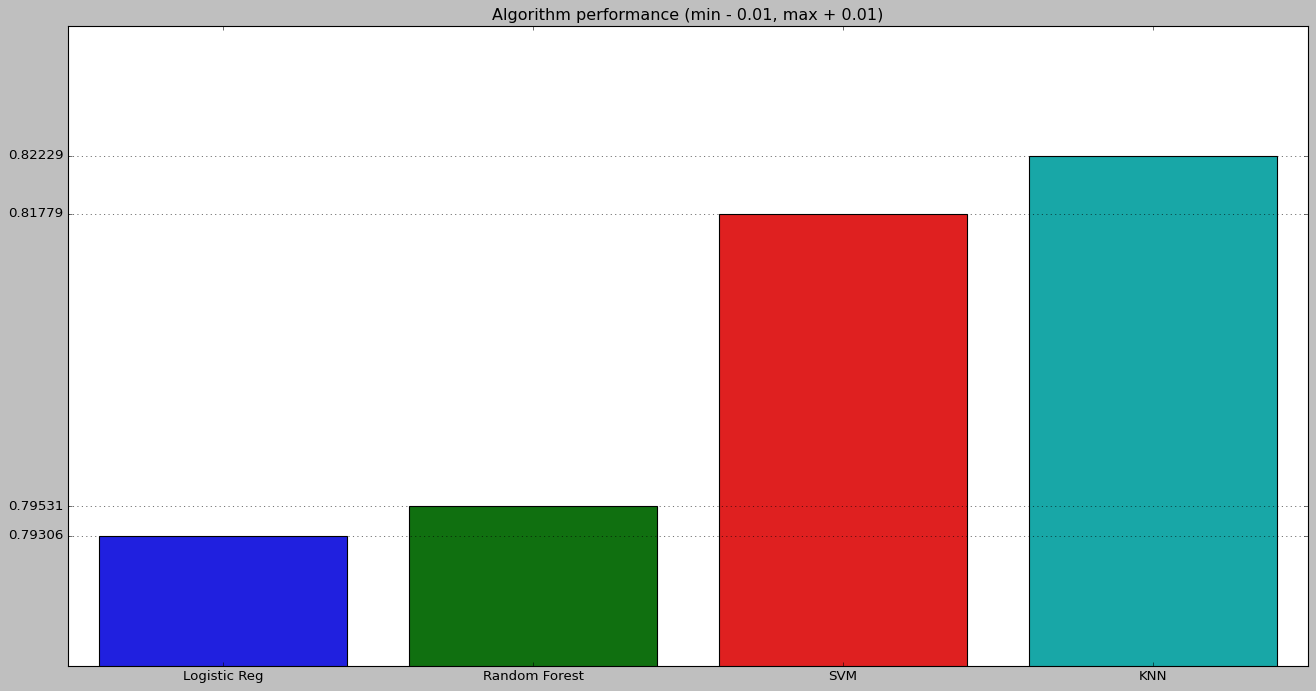

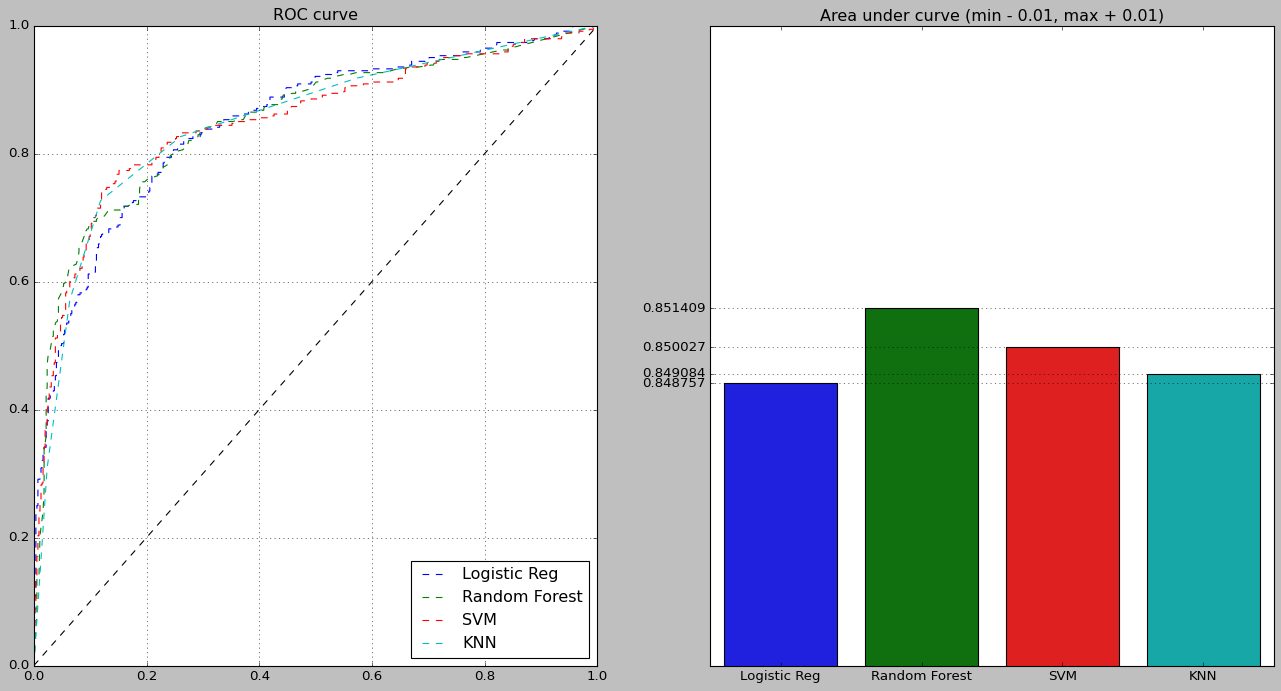

In [28]:
plot_models_performance(tuned_models)

In [29]:
from sklearn.ensemble import VotingClassifier

v_clf = VotingClassifier(estimators=[('rf', tuned_models['Random Forest']), ('svm', tuned_models['SVM']), ('knn', tuned_models['KNN'])])
model_performance(v_clf)

----- VotingClassifier -----
Scores: 	 [0.80898876 0.82022472 0.84269663 0.79775281 0.84180791]
Scores mean: 	 0.8222941661905668


0.8222941661905668

In [34]:
v_clf = v_clf.fit(X_train_scaled, y_train)
pred = v_clf.predict(X_test_scaled).astype(int)

v_submission = pd.DataFrame(data={'PassengerId': test.PassengerId, 'Survived': pred})
v_submission.to_csv('v_submission.csv', index=False)